# German traffic sign classification

### Aufgaben:
1. Suchen Sie sich 10-20 unterschiedliche Schilder aus, welche Sie mit Ihrem Modell klassifizieren wollen. Trainieren Sie dann ein Modell Ihrer Wahl. Wählen Sie danach eine der folgenden zusätzlichen Aufgaben aus:
    - Erstellen Sie ein Convolutional Neural Network und ein Fully Connected Neural Network und vergleichen Sie die Leistung beider Modelle mit Ihrem Modell.
    - Trainieren Sie ein Modell mit farbigen und ein Modell mit grauen Bildern (Farbbilder umgewandelt in Graustufen) und vergleichen Sie die Performance von beiden Modellen mit Ihrem Modell.
    - Erstellen Sie zwei weitere Modelle und vergleichen Sie deren Performance. Das zweite Modell soll alle 43 Verkehrsschilder klassifizieren und das dritte Modell nur ein Verkehrsschild erkennen können.
    - Benutzen Sie das Framework [Optuna](https://optuna.readthedocs.io/en/stable/index.html), um die Hyperparameter (Anzahl Layer, Anzahl Neuronen pro Layer, …) Ihres Modells zu optimieren. Welchen Vorteil bringt es [Optuna](https://optuna.readthedocs.io/en/stable/index.html) zu nutzen?
    - Trainieren Sie ein Modell mit einer hohen Accuracy und ein Modell mit einer geringen Latenz. Wie stark unterscheidet sich die Latenz und Accuracy von beiden Modellen. Die Latenz ist die Zeit, die das Modell braucht, ein Verkehrsschild zu klassifizieren.
    - Machen Sie eigene Bilder von Schildern und testen Sie Ihr Modell mit den eigenen Bildern. Variieren Sie Lichtverhältnisse, Wetter, … Die Bilder in den Trainingsdaten haben eine Auflösung von 32 x 32 Pixeln.
2. Sie bekommen ein paar Tage vor der Abgabe einen Testdatensatz. Testet einmal eure erstellten Modelle mit den Testdaten und prüft, wie gut die Modelle unbekannte Daten klassifizieren können.
 **Verändern Sie danach <u>nicht</u> mehr die Modelle, um ein besseres Ergebnis zu bekommen**. Das Ziel ist es zu prüfen, wie gut eure Modelle in der Realität funktionieren würden.


# Import libraries and datasets

In [218]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pickle
import random
import os

In [219]:
with open(os.path.join("dataset", "train.p"), mode='rb') as training_data:
    train = pickle.load(training_data)
with open(os.path.join("dataset", "valid.p"), mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open(os.path.join("dataset", "test.p"), mode='rb') as test_data:
    test = pickle.load(test_data)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Shuffle and configure the datasets

In [220]:
selected = 2
for index, label in enumerate(y_train):
    if label == selected:
        y_train[index] = 0
    else:
        y_train[index] = 1
for index, label in enumerate(y_valid):
    if label == selected:
        y_valid[index] = 0
    else:
        y_valid[index] = 1
for index, label in enumerate(y_test):
    if label == selected:
        y_test[index] = 0
    else:
        y_test[index] = 1

In [221]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [222]:
# Normalize image to [0, 1]
X_train_norm = X_train / 255
X_valid_norm = X_valid / 255

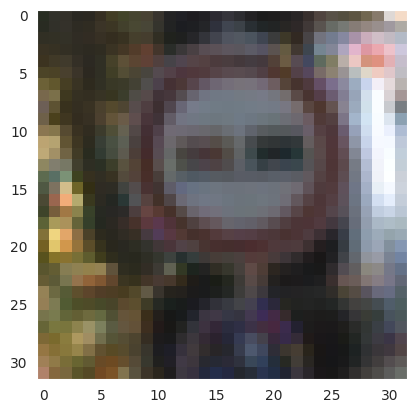

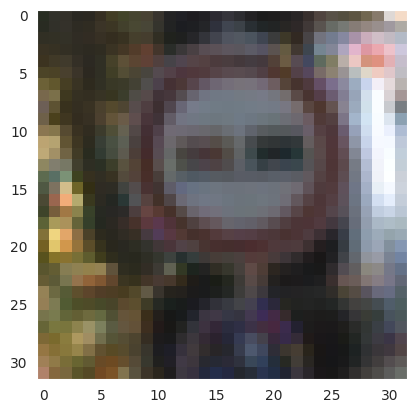

In [223]:
# Check that the images have been correctly converted and normalised
i = random.randint(1, len(X_train_norm))
plt.grid(False)
plt.imshow(X_train[i])
plt.figure()
plt.grid(False)
plt.imshow(X_train_norm[i].squeeze(), cmap = 'gray') # cmap

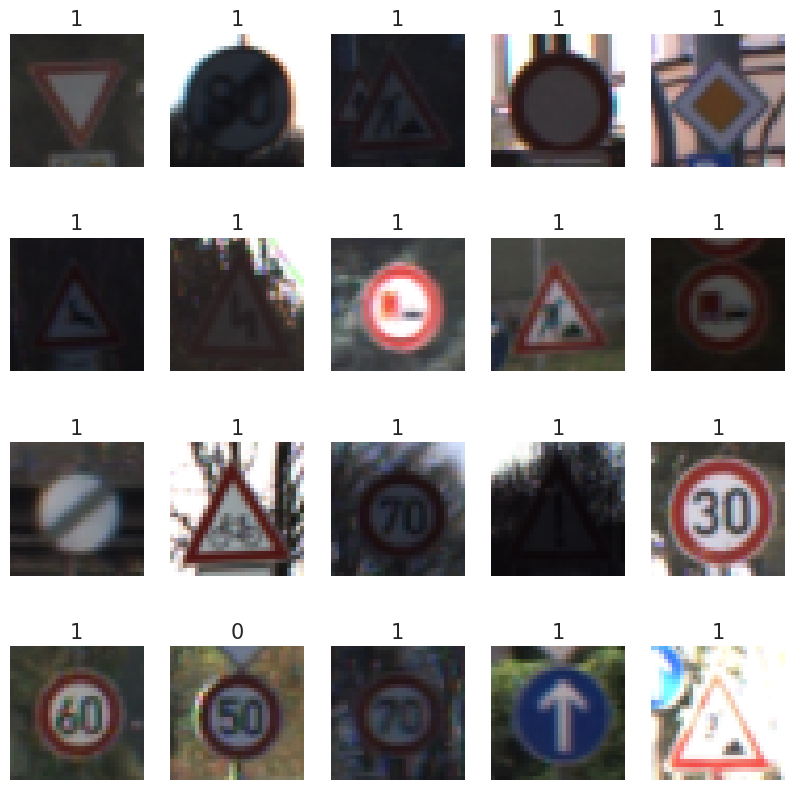

In [224]:
grid_width = 5
grid_height = 4

fig, axes = plt.subplots(grid_height, grid_width, figsize = (10,10))
axes = axes.ravel()

for i in np.arange(0, grid_width * grid_height):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index], fontsize = 15)
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.3)

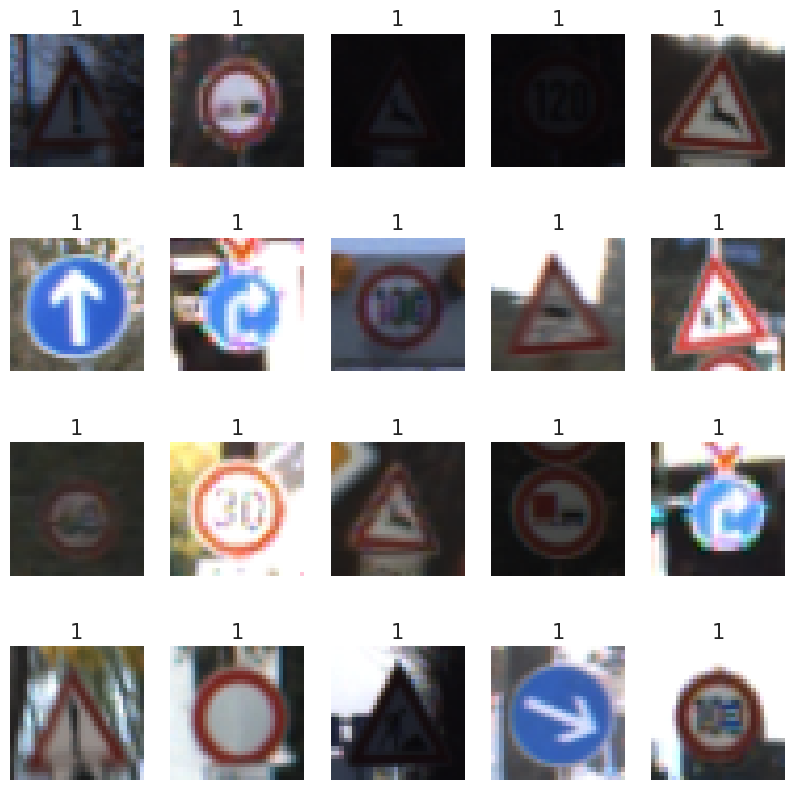

In [225]:
grid_width = 5
grid_height = 4

fig, axes = plt.subplots(grid_height, grid_width, figsize = (10,10))
axes = axes.ravel()

for i in np.arange(0, grid_width * grid_height):
    index = np.random.randint(0, len(X_valid))
    axes[i].imshow(X_valid[index])
    axes[i].set_title(y_valid[index], fontsize = 15)
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.3)

This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.# Create the Convolutional Neural Network with keras
For example a CNN that recognises handwritten numbers: [https://adamharley.com/nn_vis/cnn/2d.html](https://adamharley.com/nn_vis/cnn/2d.html)
Here a fully connected neural network that also recognise handwritten numbers: [https://adamharley.com/nn_vis/mlp/2d.html](https://adamharley.com/nn_vis/mlp/2d.html)

Use CNN.add() to add a [Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers) to your model. Here is a list of layers that might be useful:
- [Convolution Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): layers.Conv2D()
- [Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D): layers.AveragePooling2D()
- [Max Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): layers.MaxPool2D()
- [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout): layers.Dropout()
- [Flattens](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input. 2D -> 1D: layers.Flatten()
- [Densely-connected NN layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): layers.Dense()

In [226]:
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
model = keras.models.Sequential()

# Only in the first layer you have to select the input_shape of the data (image).
# TODO: Replace the question marks:
# model.add(layers.Conv2D( filters = ? , kernel_size = ( ? , ? ), padding = ? , activation = ? , input_shape = ( ? , ? , ?)))
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)))
# TODO: Add layers to the model: # Prints a summary of your network model.summary()
# model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.AvgPool2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(len(np.unique(y_train))))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_45 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 5, 5, 32)          9248      
                                                                 
 flatten_14 (Flatten)        (None, 800)             

# Compile your model
When you want, you can change the [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) or the [loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

In [227]:
model.compile(optimizer = 'Adam', loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

# Train your model
The documentation of the fit method: [https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [228]:
# TODO: Choose the batch size and the epochs
history = model.fit(x = X_train_norm,
                    y = y_train,
                    batch_size = 16,
                    epochs = 10,
                    verbose = 2,
                    validation_data = (X_valid_norm, y_valid))

Epoch 1/10
2175/2175 - 17s - loss: 0.1039 - accuracy: 0.9679 - val_loss: 0.0437 - val_accuracy: 0.9855 - 17s/epoch - 8ms/step
Epoch 2/10
2175/2175 - 14s - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.0330 - val_accuracy: 0.9887 - 14s/epoch - 7ms/step
Epoch 3/10
2175/2175 - 15s - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0136 - val_accuracy: 0.9959 - 15s/epoch - 7ms/step
Epoch 4/10
2175/2175 - 15s - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0193 - val_accuracy: 0.9946 - 15s/epoch - 7ms/step
Epoch 5/10
2175/2175 - 14s - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0127 - val_accuracy: 0.9966 - 14s/epoch - 6ms/step
Epoch 6/10
2175/2175 - 14s - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0207 - val_accuracy: 0.9964 - 14s/epoch - 6ms/step
Epoch 7/10
2175/2175 - 14s - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0181 - val_accuracy: 0.9966 - 14s/epoch - 6ms/step
Epoch 8/10
2175/2175 - 14s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0176 - val_accuracy: 0.9971 - 14s/epoch - 6

# Save your model
Create a folder for your models

In [229]:
model.save('saved_model/model_one.h5')

# Analyse the results

In [189]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [230]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

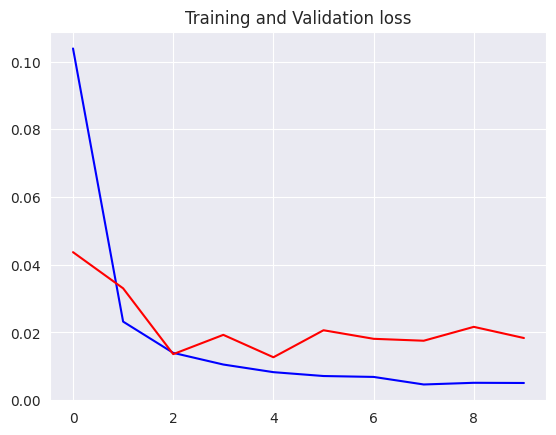

In [231]:
epochs = range(len(accuracy))
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation loss')

Text(0.5, 1.0, 'Training and Validation accuracy')

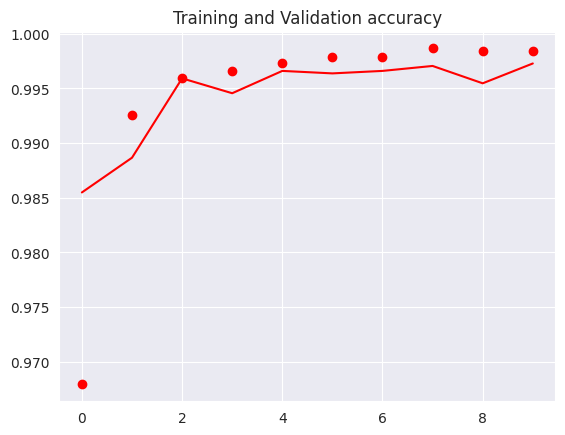

In [232]:
plt.plot(epochs, accuracy, 'ro', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')

# Load your model

In [233]:
model = tf.keras.models.load_model('saved_model/model_one.h5')

# Test your model with the test dataset
If you don't have the test dataset use the validation dataset.

In [237]:
X_test_norm = X_test / 255
score = model.evaluate(X_test_norm, y_test)
print('Test Accuracy: {}'.format(score[1]))

395/395 [==============================] - 2s 4ms/step - loss: 0.0107 - accuracy: 0.9963
Test Accuracy: 0.996278703212738


In [238]:
from sklearn.metrics import confusion_matrix
predicted_classes = np.argmax(model.predict(X_test_norm), axis=-1)
y_true = y_test

cm = confusion_matrix(y_true, predicted_classes)

395/395 [==============================] - 2s 4ms/step


<AxesSubplot: >

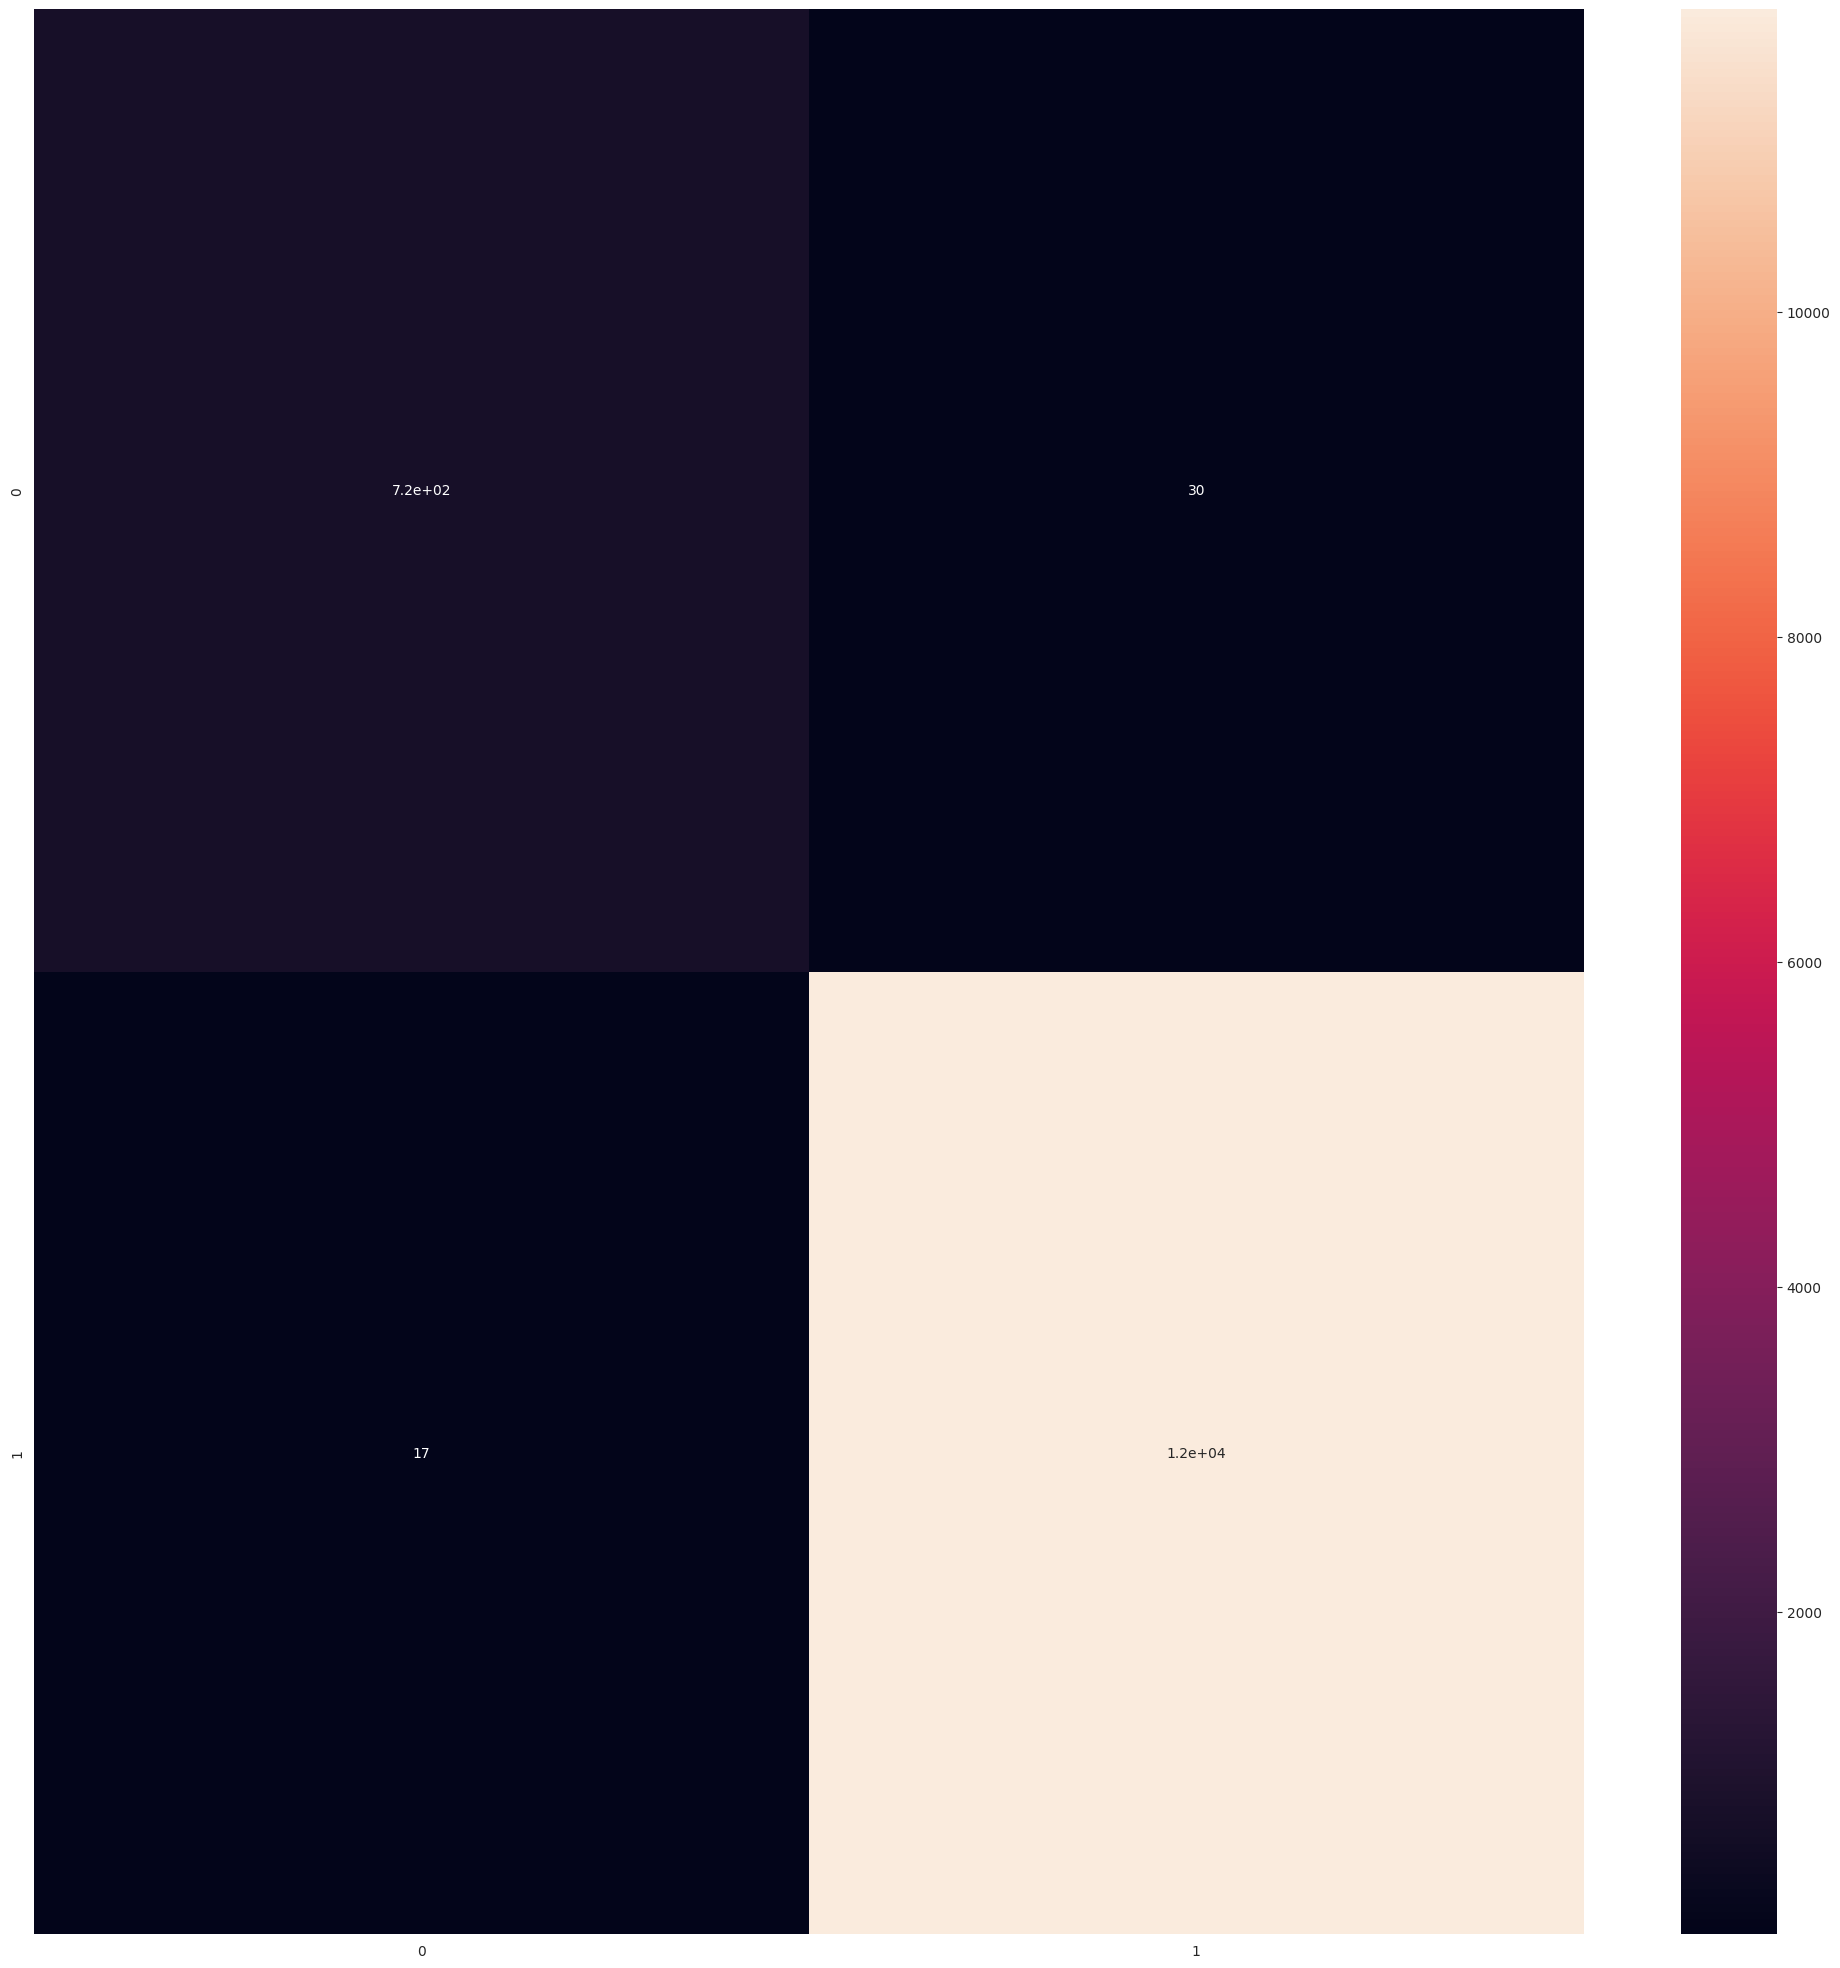

In [243]:
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)